# USING MACHINE LEARNING TO PREDICT IF A CLUB WILL QUALIFY FOR THE UEFA CHAMPIONS LEAGUE

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline 
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import os

### Load Data

In [2]:
pwd = os.getcwd()

In [3]:
df_ori = pd.read_csv(pwd + "/cleaned_data.csv")
df_ori.head()

,Unnamed: 0,league,year,position,team,matches,wins,draws,loses,goals_scored,...,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,0,La_liga,2014,1,Barcelona,38,30,4,4,110,...,28.444293,7.444293,24.727907,73.049305,5.683535,16.367593,489,114,94.0813,0.0813
1,1,La_liga,2014,2,Real Madrid,38,30,2,6,118,...,42.607198,4.607198,38.890805,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511
2,2,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,...,29.069107,0.069107,26.839271,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647
3,3,La_liga,2014,4,Valencia,38,22,11,5,70,...,39.392572,7.392572,33.446477,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932
4,4,La_liga,2014,5,Sevilla,38,23,7,8,71,...,47.862742,2.862742,41.916529,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133


In [4]:
df = df_ori.copy()
df.drop(columns = ["Unnamed: 0"], inplace = True)
df.columns

Index(['league', 'year', 'position', 'team', 'matches', 'wins', 'draws',
       'loses', 'goals_scored', 'goals_conceded', 'pts', 'xG', 'xG_diff',
       'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef',
       'deep', 'deep_allowed', 'xpts', 'xpts_diff'],
      dtype='object')

## Feature Engineering

In [5]:
# Assign id integers to the various leagues with values in range(0, df["league"].nunique()) in alphabetical order

df["league_code"] = df["league"].astype("category").cat.codes 
df.columns

Index(['league', 'year', 'position', 'team', 'matches', 'wins', 'draws',
       'loses', 'goals_scored', 'goals_conceded', 'pts', 'xG', 'xG_diff',
       'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef',
       'deep', 'deep_allowed', 'xpts', 'xpts_diff', 'league_code'],
      dtype='object')

In [6]:
# Create new column for qualification status

df["qualified"] = 0
df.columns

Index(['league', 'year', 'position', 'team', 'matches', 'wins', 'draws',
       'loses', 'goals_scored', 'goals_conceded', 'pts', 'xG', 'xG_diff',
       'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef',
       'deep', 'deep_allowed', 'xpts', 'xpts_diff', 'league_code',
       'qualified'],
      dtype='object')

In [7]:
# Assign new values to qualification columns for specific teams based on qualification criteria

for i, row in df.iterrows():

    if ((row["league_code"] == 4) and (row["position"] == 1)): 
        df.iloc[i, df.columns.get_loc("qualified")] = 1
    elif ((row['league_code'] == 3) and (row["position"] in range(1,3))):
        df.iloc[i, df.columns.get_loc("qualified")] = 1
    elif ((row['league_code'] in (0, 1, 2, 5)) and (row["position"] in range(1, 5))):
        df.iloc[i, df.columns.get_loc("qualified")] = 1
    else:
        pass
        

In [8]:
df.head()

,league,year,position,team,matches,wins,draws,loses,goals_scored,goals_conceded,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,league_code,qualified
0,La_liga,2014,1,Barcelona,38,30,4,4,110,21,...,24.727907,73.049305,5.683535,16.367593,489,114,94.0813,0.0813,2,1
1,La_liga,2014,2,Real Madrid,38,30,2,6,118,38,...,38.890805,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511,2,1
2,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,29,...,26.839271,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647,2,1
3,La_liga,2014,4,Valencia,38,22,11,5,70,32,...,33.446477,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932,2,1
4,La_liga,2014,5,Sevilla,38,23,7,8,71,45,...,41.916529,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133,2,0


## Model Initialization

In [9]:
# Set baseline threshold

acc_baseline = df["qualified"].value_counts(normalize = True).max()
print("The baseline accuracy is:", round(acc_baseline, 2))

The baseline accuracy is: 0.83


### Linear Regression Model

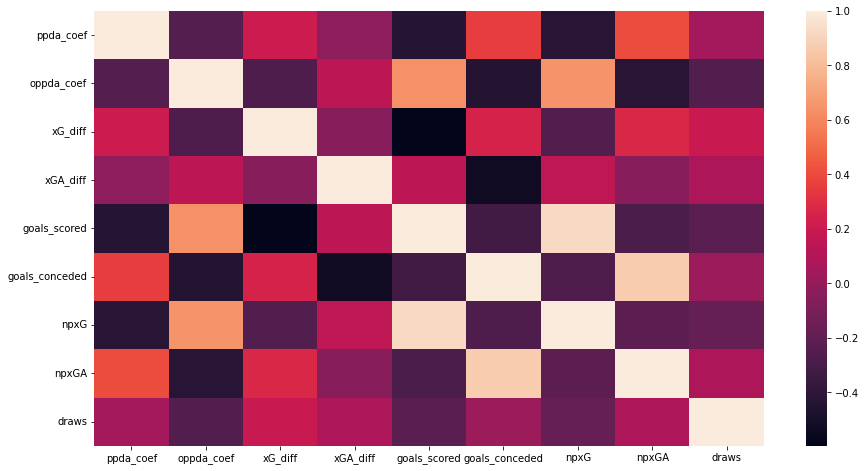

In [10]:
# Check chosen features for correlation

plt.figure(figsize = [15, 8])

features = df[["ppda_coef", "oppda_coef", "xG_diff", "xGA_diff", 
    "goals_scored", "goals_conceded", "npxG", "npxGA", "draws"]].copy()
sns.heatmap(features.corr());

In [11]:
# Set feature matrix and target vector

features = ["ppda_coef", "oppda_coef", "xG_diff", "xGA_diff", 
    "goals_scored", "goals_conceded", "npxG", "npxGA", "draws", "league"]
target = "qualified"

X = df[features]
y = df[target]

print(X.shape)
print(y.shape)

(684, 10)
(684,)


In [12]:
# Train - Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (478, 10)
y_train shape: (478,)
X_test shape: (206, 10)
y_test shape: (206,)


In [13]:
# Build and Train Model 
 

l_model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter = 1500)
)

l_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['league'], use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1500))])

In [14]:
# Check Model Accuracy

train_acc = accuracy_score(y_train, l_model.predict(X_train))
test_acc = accuracy_score(y_test, l_model.predict(X_test))

print("Training accuracy:", round(train_acc, 2))
print("Testing accuracy:", round(test_acc, 2))

Training accuracy: 0.94
Testing accuracy: 0.96


In [15]:
# Check confusion matrix to investigate model's true performance

l_model_cm = confusion_matrix(y_test, l_model.predict(X_test))
l_model_cm

array([[165,   6],
       [  3,  32]], dtype=int64)

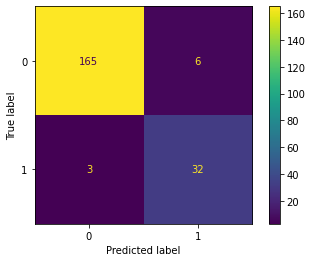

In [17]:
# Visualize confusion matrix.

l_model_cmd = ConfusionMatrixDisplay(confusion_matrix = l_model_cm)
l_model_cmd.plot();

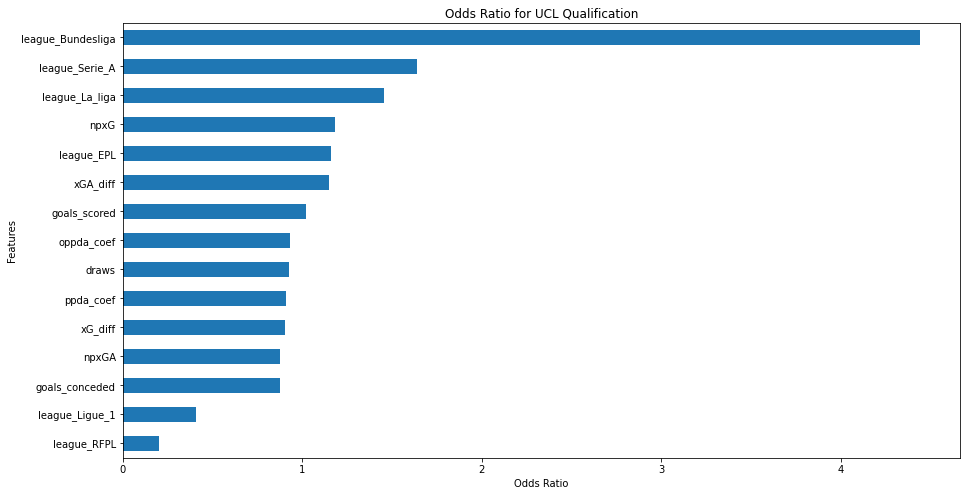

In [18]:
# Check Model's Odd Ratio for Features

plt.figure(figsize = [15, 8])

features = l_model.named_steps["onehotencoder"].get_feature_names()
importances = l_model.named_steps["logisticregression"].coef_[0]

odds_ratio = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratio.plot(kind = "barh");
plt.xlabel("Odds Ratio")
plt.ylabel("Features")
plt.title("Odds Ratio for UCL Qualification");

### Decision Tree Model

In [19]:
tree_df = df.copy()
tree_df.columns

Index(['league', 'year', 'position', 'team', 'matches', 'wins', 'draws',
       'loses', 'goals_scored', 'goals_conceded', 'pts', 'xG', 'xG_diff',
       'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef',
       'deep', 'deep_allowed', 'xpts', 'xpts_diff', 'league_code',
       'qualified'],
      dtype='object')

In [20]:
# Create feature matrix and target vector

tree_features = ['league', 'wins', 'draws',
       'loses', 'goals_scored', 'goals_conceded', 'pts', 'xG', 'xG_diff',
       'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef',
       'deep', 'deep_allowed', 'xpts', 'xpts_diff']

X_tree = df[tree_features]
y_tree = df[target]

print(X_tree.shape)
print(y_tree.shape)


(684, 20)
(684,)


In [21]:
# Train - Test split

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size = 0.15, random_state = 42
)

print("X_tree_train shape:", X_tree_train.shape)
print("y_tree_train shape:", y_tree_train.shape)
print("X_tree_test shape:", X_tree_test.shape)
print("y_tree_test shape:", y_tree_test.shape)

X_tree_train shape: (581, 20)
y_tree_train shape: (581,)
X_tree_test shape: (103, 20)
y_tree_test shape: (103,)


In [22]:
# Train - Validation Split

X_tree_train, X_tree_val, y_tree_train, y_tree_val = train_test_split(
    X_tree_train, y_tree_train, test_size = 0.18, random_state = 42
)

print("X_tree_train shape:", X_tree_train.shape)
print("y_tree_train shape:", y_tree_train.shape)
print("X_tree_val shape:", X_tree_val.shape)
print("y_tree_val shape:", y_tree_val.shape)

X_tree_train shape: (476, 20)
y_tree_train shape: (476,)
X_tree_val shape: (105, 20)
y_tree_val shape: (105,)


In [23]:
# Build and train

tree_model = make_pipeline(
    OneHotEncoder(), 
    DecisionTreeClassifier(random_state = 42)
)

tree_model.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['league'])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [24]:
# Check model's accuracy

tree_train_acc = accuracy_score(y_tree_train, tree_model.predict(X_tree_train))
tree_val_acc = accuracy_score(y_tree_val, tree_model.predict(X_tree_val))

print("Training accuracy:", round(tree_train_acc, 2))
print("Validation accuracy:", round(tree_val_acc, 2))

Training accuracy: 1.0
Validation accuracy: 0.92


In [25]:
# Check tree's depth

tree_model.named_steps["decisiontreeclassifier"].get_depth()

5

*Hyperparameter tuning*

In [26]:
# Set value range for depth hyper parameter

depth_hyperparams = range(1, 6)

In [27]:
# Train models with the different depths

training_acc = []
validation_acc = []

for d in depth_hyperparams:

    test_model = make_pipeline(
        OneHotEncoder(),
        DecisionTreeClassifier(max_depth = d, random_state = 42)
    )

    test_model.fit(X_tree_train, y_tree_train)

    training_acc.append(accuracy_score(y_tree_train, test_model.predict(X_tree_train)))
    
    validation_acc.append(accuracy_score(y_tree_val, test_model.predict(X_tree_val)))


print("Training Accuracy Scores:", training_acc[:])
print("Validation Accuracy Scores:", validation_acc[:])

Training Accuracy Scores: [0.9411764705882353, 0.9495798319327731, 0.9684873949579832, 0.9810924369747899, 1.0]
Validation Accuracy Scores: [0.9619047619047619, 0.9714285714285714, 0.9523809523809523, 0.9428571428571428, 0.9238095238095239]


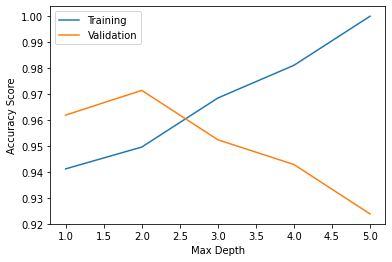

In [28]:
# Plot accuracy score against tree depth to aid choice on best depth.

plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [29]:
# Build and train tuned tree model

tuned_tree_model = make_pipeline(
    OneHotEncoder(), 
    DecisionTreeClassifier(max_depth = 2.5, random_state = 42)
)

tuned_tree_model.fit(X_tree_train, y_tree_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['league'])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=2.5, random_state=42))])

In [30]:
# Check tuned model's accuracy

tuned_tree_train_acc = accuracy_score(y_tree_train, tuned_tree_model.predict(X_tree_train))
tuned_tree_val_acc = accuracy_score(y_tree_val, tuned_tree_model.predict(X_tree_val))

print("Tuned Tree Training accuracy:", round(tuned_tree_train_acc, 2))
print("Tuned Tree Validation accuracy:", round(tuned_tree_val_acc, 2))

Tuned Tree Training accuracy: 0.95
Tuned Tree Validation accuracy: 0.97


In [31]:
# Apply new hyperparameter, train and test model.

tuned_tree_test_acc = accuracy_score(y_tree_test, tuned_tree_model.predict(X_tree_test))

print("Tuned Tree Testing accuracy:", round(tuned_tree_test_acc, 2))

Tuned Tree Testing accuracy: 0.94


In [32]:
# Build confusion matrix to undesrstand model's performance.

tree_cm = confusion_matrix(y_tree_test, tuned_tree_model.predict(X_tree_test))
tree_cm

array([[84,  4],
       [ 2, 13]], dtype=int64)

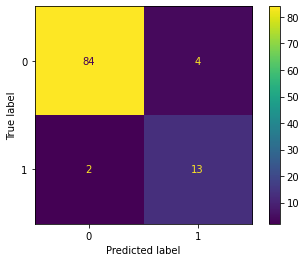

In [34]:
# Visualize confusion matrix.

tree_cmd = ConfusionMatrixDisplay(confusion_matrix = tree_cm)
tree_cmd.plot();

In [48]:
import pickle 

In [49]:
# Pickle linear model

with open("linear_ucl_model", "wb") as f:
    pickle.dump(l_model, f)

In [51]:
# Pickle tuned tree model

with open("tuned_tree_ucl_model", "wb") as m:
    pickle.dump(tuned_tree_model, m)